# League of Legends Match Data Analysis
## Data Cleaning, Feature Engineering, and Exploratory Visualization

This notebook processes 48,360 League of Legends matches with 100,000+ player statistics from EUW region.

**Dataset Overview:**
- 48,360 matches (ARAM + CLASSIC)
- 2,381 unique summoners
- Patches 13.22 through 15.1
- Ranks: Unranked to Challenger


## 1. Setup and Imports


In [19]:
#data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re

#plot settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)



## 2. Data Loading


In [20]:
# loading data
champions_df = pd.read_csv('data/raw_data/ChampionTbl.csv')
items_df = pd.read_csv('data/raw_data/ItemTbl.csv')
ranks_df = pd.read_csv('data/raw_data/RankTbl.csv')
matches_df = pd.read_csv('data/raw_data/MatchTbl.csv')
team_matches_df = pd.read_csv('data/raw_data/TeamMatchTbl.csv')
summoner_matches_df = pd.read_csv('data/raw_data/SummonerMatchTbl.csv')
match_stats_df = pd.read_csv('data/raw_data/MatchStatsTbl.csv')

# quick display
datasets = {
    'Champions': champions_df,
    'Items': items_df,
    'Ranks': ranks_df,
    'Matches': matches_df,
    'Team Matches': team_matches_df,
    'Summoner Matches': summoner_matches_df,
    'Match Stats': match_stats_df
}

for name, df in datasets.items():
    print(f"{name:20s}: {len(df):,} rows x {len(df.columns)} columns")

print("\nAll datasets loaded successfully!")


Champions           : 172 rows x 2 columns
Items               : 635 rows x 2 columns
Ranks               : 11 rows x 2 columns
Matches             : 48,359 rows x 5 columns
Team Matches        : 47,895 rows x 24 columns
Summoner Matches    : 106,966 rows x 4 columns
Match Stats         : 106,966 rows x 31 columns

All datasets loaded successfully!


## 3. Initial Data Exploration


In [21]:
# missing values
for name, df in datasets.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n{name}:")
        print(missing[missing > 0])
    else:
        print(f"\n{name}: No missing values")



Champions: No missing values

Items: No missing values

Ranks: No missing values

Matches: No missing values

Team Matches: No missing values

Summoner Matches: No missing values

Match Stats: No missing values


In [22]:
#quick display of data
print("SAMPLE DATA")

print("\nMatch Stats (first 5 rows):")
display(match_stats_df.head())
print("\nMatches (first 5 rows):")
display(matches_df.head())
print("\nTeam Matches (first 5 rows):")
display(team_matches_df.head())


SAMPLE DATA

Match Stats (first 5 rows):


,MatchStatsId,SummonerMatchFk,MinionsKilled,DmgDealt,DmgTaken,TurretDmgDealt,TotalGold,Lane,Win,item1,item2,item3,item4,item5,item6,kills,deaths,assists,PrimaryKeyStone,PrimarySlot1,PrimarySlot2,PrimarySlot3,SecondarySlot1,SecondarySlot2,SummonerSpell1,SummonerSpell2,CurrentMasteryPoints,EnemyChampionFk,DragonKills,BaronKills,visionScore
0,1,1,30,4765,12541,0,7058,BOTTOM,0,3870,2055,3107,3171,6620,2022,0,2,12,8465,8463,8473,8453,8345,8347,4,7,902,51,0,0,67
1,2,2,29,8821,14534,1,9618,BOTTOM,0,3870,2065,3107,3158,6620,3916,2,5,23,8465,8463,8473,8453,8345,8347,4,7,902,236,0,0,88
2,3,3,34,6410,19011,3,9877,BOTTOM,1,3870,3107,1011,3171,6617,3916,0,5,22,8214,8226,8210,8237,8345,8347,4,7,16,498,0,0,97
3,4,4,51,22206,14771,3,12374,NONE,1,6655,3089,4645,3020,0,0,8,4,35,8112,8143,8140,8106,8226,8210,4,14,103,54,0,0,0
4,5,5,0,39106,33572,0,15012,TOP,1,4015,223157,226653,222503,223089,447108,13,8,2,0,0,0,0,0,0,2202,2201,800,12,0,0,0



Matches (first 5 rows):


,MatchId,Patch,QueueType,RankFk,GameDuration
0,EUN1_3707659547,14.23.636.9832,ARAM,0,1173
1,EUN1_3709211408,14.24.642.1879,CLASSIC,0,1986
2,EUN1_3710823249,14.24.643.5128,ARAM,0,813
3,EUN1_3710849604,14.24.643.5128,ARAM,0,1070
4,EUN1_3710885279,14.24.643.5128,ARAM,0,968



Team Matches (first 5 rows):


,TeamID,MatchFk,B1Champ,B2Champ,B3Champ,B4Champ,B5Champ,R1Champ,R2Champ,R3Champ,R4Champ,R5Champ,BlueBaronKills,BlueRiftHeraldKills,BlueDragonKills,BlueTowerKills,BlueKills,RedBaronKills,RedRiftHeraldKills,RedDragonKills,RedTowerKills,RedKills,RedWin,BlueWin
0,1,EUW1_7565751492,897,154,157,51,902,164,5,25,221,497,0,1,1,3,13,1,0,3,8,26,1,0
1,2,EUW1_7565549583,82,238,157,236,89,6,254,127,42,902,1,0,3,10,39,0,1,1,3,33,0,1
2,3,EUW1_7564803077,516,28,4,498,235,23,64,38,901,16,0,1,2,7,27,2,0,3,8,37,1,0
3,4,EUW1_7564368646,54,34,59,498,103,61,25,55,106,5,0,0,0,4,55,0,0,0,0,39,0,1
4,5,EUW1_7564332041,12,800,111,150,142,141,101,55,950,4,0,0,0,0,42,0,0,0,0,0,0,1


In [23]:
#checking data distribution and duplicate values

print(f"\nMatch Stats unique IDs: {match_stats_df['MatchStatsId'].nunique():,} / {len(match_stats_df):,}")
print(f"Unique Matches: {matches_df['MatchId'].nunique():,}")
print(f"Unique Summoners in SummonerMatches: {summoner_matches_df['SummonerFk'].nunique():,}")
print("\nQueue Type Distribution:")
print(matches_df['QueueType'].value_counts())
print("\nRank Distribution:")
rank_dist = matches_df['RankFk'].value_counts().sort_index()
for rank_id, count in rank_dist.items():
    rank_name = ranks_df[ranks_df['RankId'] == rank_id]['RankName'].values
    rank_name = rank_name[0] if len(rank_name) > 0 else 'Unknown'
    print(f"  {rank_name:15s}: {count:,} matches ({count/len(matches_df)*100:.1f}%)")



Match Stats unique IDs: 106,966 / 106,966
Unique Matches: 48,359
Unique Summoners in SummonerMatches: 2,944

Queue Type Distribution:
QueueType
CLASSIC      33696
CHERRY        7484
ARAM          6316
SWIFTPLAY      849
ULTBOOK         14
Name: count, dtype: int64

Rank Distribution:
  Unranked       : 6,226 matches (12.9%)
  Iron           : 711 matches (1.5%)
  Bronze         : 1,677 matches (3.5%)
  Silver         : 4,676 matches (9.7%)
  Gold           : 5,562 matches (11.5%)
  Platinum       : 5,932 matches (12.3%)
  Emerald        : 5,668 matches (11.7%)
  Diamond        : 2,987 matches (6.2%)
  Master         : 13,741 matches (28.4%)
  Grandmaster    : 956 matches (2.0%)
  Challenger     : 223 matches (0.5%)


## 4. Data Cleaning

### 4.1 Filter to 'classic' Game Mode Only

this makes our data more consistent (stats change vastly between different game modes)

In [24]:
# filter matches to only CLASSIC game mode (exclude ARAM, etc.)
print("Filtering to 'classic' game mode only...\n")

# before filtering
print("Before filtering:")
print(matches_df['QueueType'].value_counts())
print(f"Total matches: {len(matches_df):,}")
print(f"Total match stats: {len(match_stats_df):,}")

classic_matches = matches_df[matches_df['QueueType'] == 'CLASSIC']['MatchId'].unique()
print(f"\nclassic matches: {len(classic_matches):,}")
matches_df = matches_df[matches_df['QueueType'] == 'CLASSIC'].copy()
team_matches_df = team_matches_df[team_matches_df['MatchFk'].isin(classic_matches)].copy()
summoner_matches_df = summoner_matches_df[summoner_matches_df['MatchFk'].isin(classic_matches)].copy()
classic_summoner_match_ids = summoner_matches_df['SummonerMatchId'].unique()
match_stats_df = match_stats_df[match_stats_df['SummonerMatchFk'].isin(classic_summoner_match_ids)].copy()

print(f"\nAfter filtering to classic only:")
print(f"Matches: {len(matches_df):,}")
print(f"Team Matches: {len(team_matches_df):,}")
print(f"Summoner Matches: {len(summoner_matches_df):,}")
print(f"Match Stats: {len(match_stats_df):,}")
print(f"\nFiltered to classic mode only (removed ARAM and other modes)")


Filtering to 'classic' game mode only...

Before filtering:
QueueType
CLASSIC      33696
CHERRY        7484
ARAM          6316
SWIFTPLAY      849
ULTBOOK         14
Name: count, dtype: int64
Total matches: 48,359
Total match stats: 106,966

classic matches: 33,696



After filtering to classic only:
Matches: 33,696
Team Matches: 33,456
Summoner Matches: 75,897
Match Stats: 75,897

Filtered to classic mode only (removed ARAM and other modes)


### 4.2 Clean Item Names


In [25]:
def clean_item_name(name: str) -> str:
    """Remove HTML tags and clean item names"""
    # Remove HTML tags
    name = re.sub(r'<[^>]+>', '', name)
    # Remove extra whitespace
    name = ' '.join(name.split())
    return name

# Apply cleaning
items_df['ItemName_Clean'] = items_df['ItemName'].apply(clean_item_name)

# Show examples of cleaning
print("Item Name Cleaning Examples:")
dirty_items = items_df[items_df['ItemName'].str.contains('<', na=False)].head(5)
if len(dirty_items) > 0:
    for _, row in dirty_items.iterrows():
        print(f"  Before: {row['ItemName']}")
        print(f"  After:  {row['ItemName_Clean']}")
        print()

print(f"Cleaned {len(items_df)} item names")


Item Name Cleaning Examples:
  Before: <rarityLegendary>Fire at Will</rarityLegendary><br><subtitleLeft><silver>500 Silver Serpents</silver></subtitleLeft>
  After:  Fire at Will500 Silver Serpents

  Before: <rarityLegendary>Death's Daughter</rarityLegendary><br><subtitleLeft><silver>500 Silver Serpents</silver></subtitleLeft>
  After:  Death's Daughter500 Silver Serpents

  Before: <rarityLegendary>Raise Morale</rarityLegendary><br><subtitleLeft><silver>500 Silver Serpents</silver></subtitleLeft>
  After:  Raise Morale500 Silver Serpents

Cleaned 635 item names


### 4.3 Identify Support vs ADC (Bottom Lane)


In [26]:
# Traditional support champions (by ChampionId)
SUPPORT_CHAMPIONS = {
    12, 201, 53, 432, 40, 89, 99, 25, 267, 111, 37, 16, 44, 412, 223,
    350, 143, 26, 117, 497, 555, 526, 235, 888, 902
}

# CS threshold for support identification
CS_THRESHOLD = 50

def identify_role(row):
    """Identify if a BOTTOM lane player is Support or ADC"""
    if row['Lane'] == 'BOTTOM':
        # Get champion ID for this player
        champion_id = summoner_matches_df[
            summoner_matches_df['SummonerMatchId'] == row['SummonerMatchFk']
        ]['ChampionFk'].values
        
        if len(champion_id) > 0:
            champion_id = champion_id[0]
            # Traditional support champion OR low CS
            if champion_id in SUPPORT_CHAMPIONS or row['MinionsKilled'] < CS_THRESHOLD:
                return 'SUPPORT'
            else:
                return 'ADC'
    return row['Lane']

# Create a copy for processing
match_stats_clean = match_stats_df.copy()

# Apply role identification
print("Identifying ADC vs Support roles...")
match_stats_clean['Role'] = match_stats_clean.apply(identify_role, axis=1)

# Show results
print("\nRole Distribution:")
print(match_stats_clean['Role'].value_counts())

# Compare before/after
bottom_before = len(match_stats_df[match_stats_df['Lane'] == 'BOTTOM'])
support_after = len(match_stats_clean[match_stats_clean['Role'] == 'SUPPORT'])
adc_after = len(match_stats_clean[match_stats_clean['Role'] == 'ADC'])

print(f"\nBOTTOM lane breakdown:")
print(f"  Before: {bottom_before:,} BOTTOM lane entries")
print(f"  After:  {support_after:,} SUPPORT + {adc_after:,} ADC")
print("\nRole identification complete")


Identifying ADC vs Support roles...

Role Distribution:
Role
MIDDLE     14837
JUNGLE     14278
TOP        13734
ADC        13105
SUPPORT    11006
NONE        8937
Name: count, dtype: int64

BOTTOM lane breakdown:
  Before: 19,231 BOTTOM lane entries
  After:  11,006 SUPPORT + 13,105 ADC

Role identification complete


### 4.4 Create Derived Features


In [27]:
# Merge match duration and other match info
match_stats_clean = match_stats_clean.merge(
    summoner_matches_df[['SummonerMatchId', 'ChampionFk', 'SummonerFk', 'MatchFk']],
    left_on='SummonerMatchFk',
    right_on='SummonerMatchId',
    how='left'
)

match_stats_clean = match_stats_clean.merge(
    matches_df[['MatchId', 'GameDuration', 'QueueType', 'RankFk', 'Patch']],
    left_on='MatchFk',
    right_on='MatchId',
    how='left'
)

print("Creating derived features...\n")

# 1. KDA Ratio
match_stats_clean['KDA'] = (
    (match_stats_clean['kills'] + match_stats_clean['assists']) / 
    match_stats_clean['deaths'].replace(0, 1)
)

# 2. Per-minute metrics
match_stats_clean['GameDurationMin'] = match_stats_clean['GameDuration'] / 60
match_stats_clean['GoldPerMin'] = match_stats_clean['TotalGold'] / match_stats_clean['GameDurationMin']
match_stats_clean['CSPerMin'] = match_stats_clean['MinionsKilled'] / match_stats_clean['GameDurationMin']
match_stats_clean['DmgPerMin'] = match_stats_clean['DmgDealt'] / match_stats_clean['GameDurationMin']
match_stats_clean['VisionPerMin'] = match_stats_clean['visionScore'] / match_stats_clean['GameDurationMin']

# 3. Efficiency metrics
match_stats_clean['DmgPerGold'] = match_stats_clean['DmgDealt'] / match_stats_clean['TotalGold']
match_stats_clean['DmgEfficiency'] = match_stats_clean['DmgDealt'] / match_stats_clean['DmgTaken'].replace(0, 1)

# 4. Game phase classification
def classify_game_phase(duration_min):
    if duration_min < 20:
        return 'Early'
    elif duration_min < 35:
        return 'Mid'
    else:
        return 'Late'

match_stats_clean['GamePhase'] = match_stats_clean['GameDurationMin'].apply(classify_game_phase)

# 5. Item count
item_cols = ['item1', 'item2', 'item3', 'item4', 'item5', 'item6']
match_stats_clean['ItemCount'] = (match_stats_clean[item_cols] != 0).sum(axis=1)

# 6. Objective participation
match_stats_clean['ObjectiveParticipation'] = (
    match_stats_clean['DragonKills'] + match_stats_clean['BaronKills']
)

# Add champion and rank info
match_stats_clean = match_stats_clean.merge(
    champions_df,
    left_on='ChampionFk',
    right_on='ChampionId',
    how='left'
)

match_stats_clean = match_stats_clean.merge(
    ranks_df,
    left_on='RankFk',
    right_on='RankId',
    how='left'
)

print("Derived features created:")
derived_features = [
    'KDA', 'GoldPerMin', 'CSPerMin', 'DmgPerMin', 'VisionPerMin',
    'DmgPerGold', 'DmgEfficiency', 'GamePhase', 'ItemCount', 'ObjectiveParticipation'
]
for feature in derived_features:
    print(f"   {feature}")

print(f"\nFeature engineering complete!")
print(f"Total columns: {len(match_stats_clean.columns)}")


Creating derived features...

Derived features created:
   KDA
   GoldPerMin
   CSPerMin
   DmgPerMin
   VisionPerMin
   DmgPerGold
   DmgEfficiency
   GamePhase
   ItemCount
   ObjectiveParticipation

Feature engineering complete!
Total columns: 56


### 4.5 Handle Missing/Invalid Values


In [28]:
print("Handling missing and invalid values...\n")

# Check for ChampionId = 0
no_champion = match_stats_clean[match_stats_clean['ChampionFk'] == 0]
print(f"Records with ChampionId = 0: {len(no_champion)}")

if len(no_champion) > 0:
    print("  → Removing invalid champion records")
    match_stats_clean = match_stats_clean[match_stats_clean['ChampionFk'] != 0]

# Replace infinite values
match_stats_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN in derived metrics with median
for col in ['KDA', 'DmgPerGold', 'DmgEfficiency']:
    if col in match_stats_clean.columns:
        match_stats_clean[col].fillna(match_stats_clean[col].median(), inplace=True)

print(f"\nData cleaning complete!")
print(f"Final dataset: {len(match_stats_clean):,} records")
print(f"\nSample of cleaned data:")
display(match_stats_clean[[
    'ChampionName', 'Role', 'Win', 'kills', 'deaths', 'assists', 'KDA',
    'GoldPerMin', 'CSPerMin', 'GamePhase', 'RankName', 'QueueType'
]].head(10))


Handling missing and invalid values...

Records with ChampionId = 0: 0

Data cleaning complete!
Final dataset: 75,897 records

Sample of cleaned data:


C:\Users\Kaw Bu\AppData\Local\Temp\ipykernel_12328\121860245.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,ChampionName,Role,Win,kills,deaths,assists,KDA,GoldPerMin,CSPerMin,GamePhase,RankName,QueueType
0,Milio,SUPPORT,0,0,2,12,6.00,241.850371,1.027984,Mid,Diamond,CLASSIC
1,Milio,SUPPORT,0,2,5,23,5.00,275.850860,0.831740,Mid,Diamond,CLASSIC
2,Soraka,SUPPORT,1,0,5,22,4.40,254.125214,0.874786,Late,Diamond,CLASSIC
3,Milio,SUPPORT,0,0,1,7,7.00,227.112172,1.002387,Mid,Diamond,CLASSIC
4,Nami,SUPPORT,0,1,5,6,1.40,253.962264,1.234991,Mid,Diamond,CLASSIC
5,Milio,SUPPORT,1,2,2,30,16.00,308.819715,0.804150,Late,Diamond,CLASSIC
6,Soraka,SUPPORT,0,0,2,14,7.00,239.195980,1.005025,Mid,Diamond,CLASSIC
7,Nami,SUPPORT,1,1,2,26,13.50,320.799523,1.217184,Mid,Diamond,CLASSIC
8,Milio,SUPPORT,1,1,1,12,13.00,255.364178,0.797068,Late,Diamond,CLASSIC
9,Seraphine,SUPPORT,1,6,4,19,6.25,386.496956,1.627006,Mid,Diamond,CLASSIC


## 5. Exploratory Data Analysis

### 5.1 Distribution Visualizations


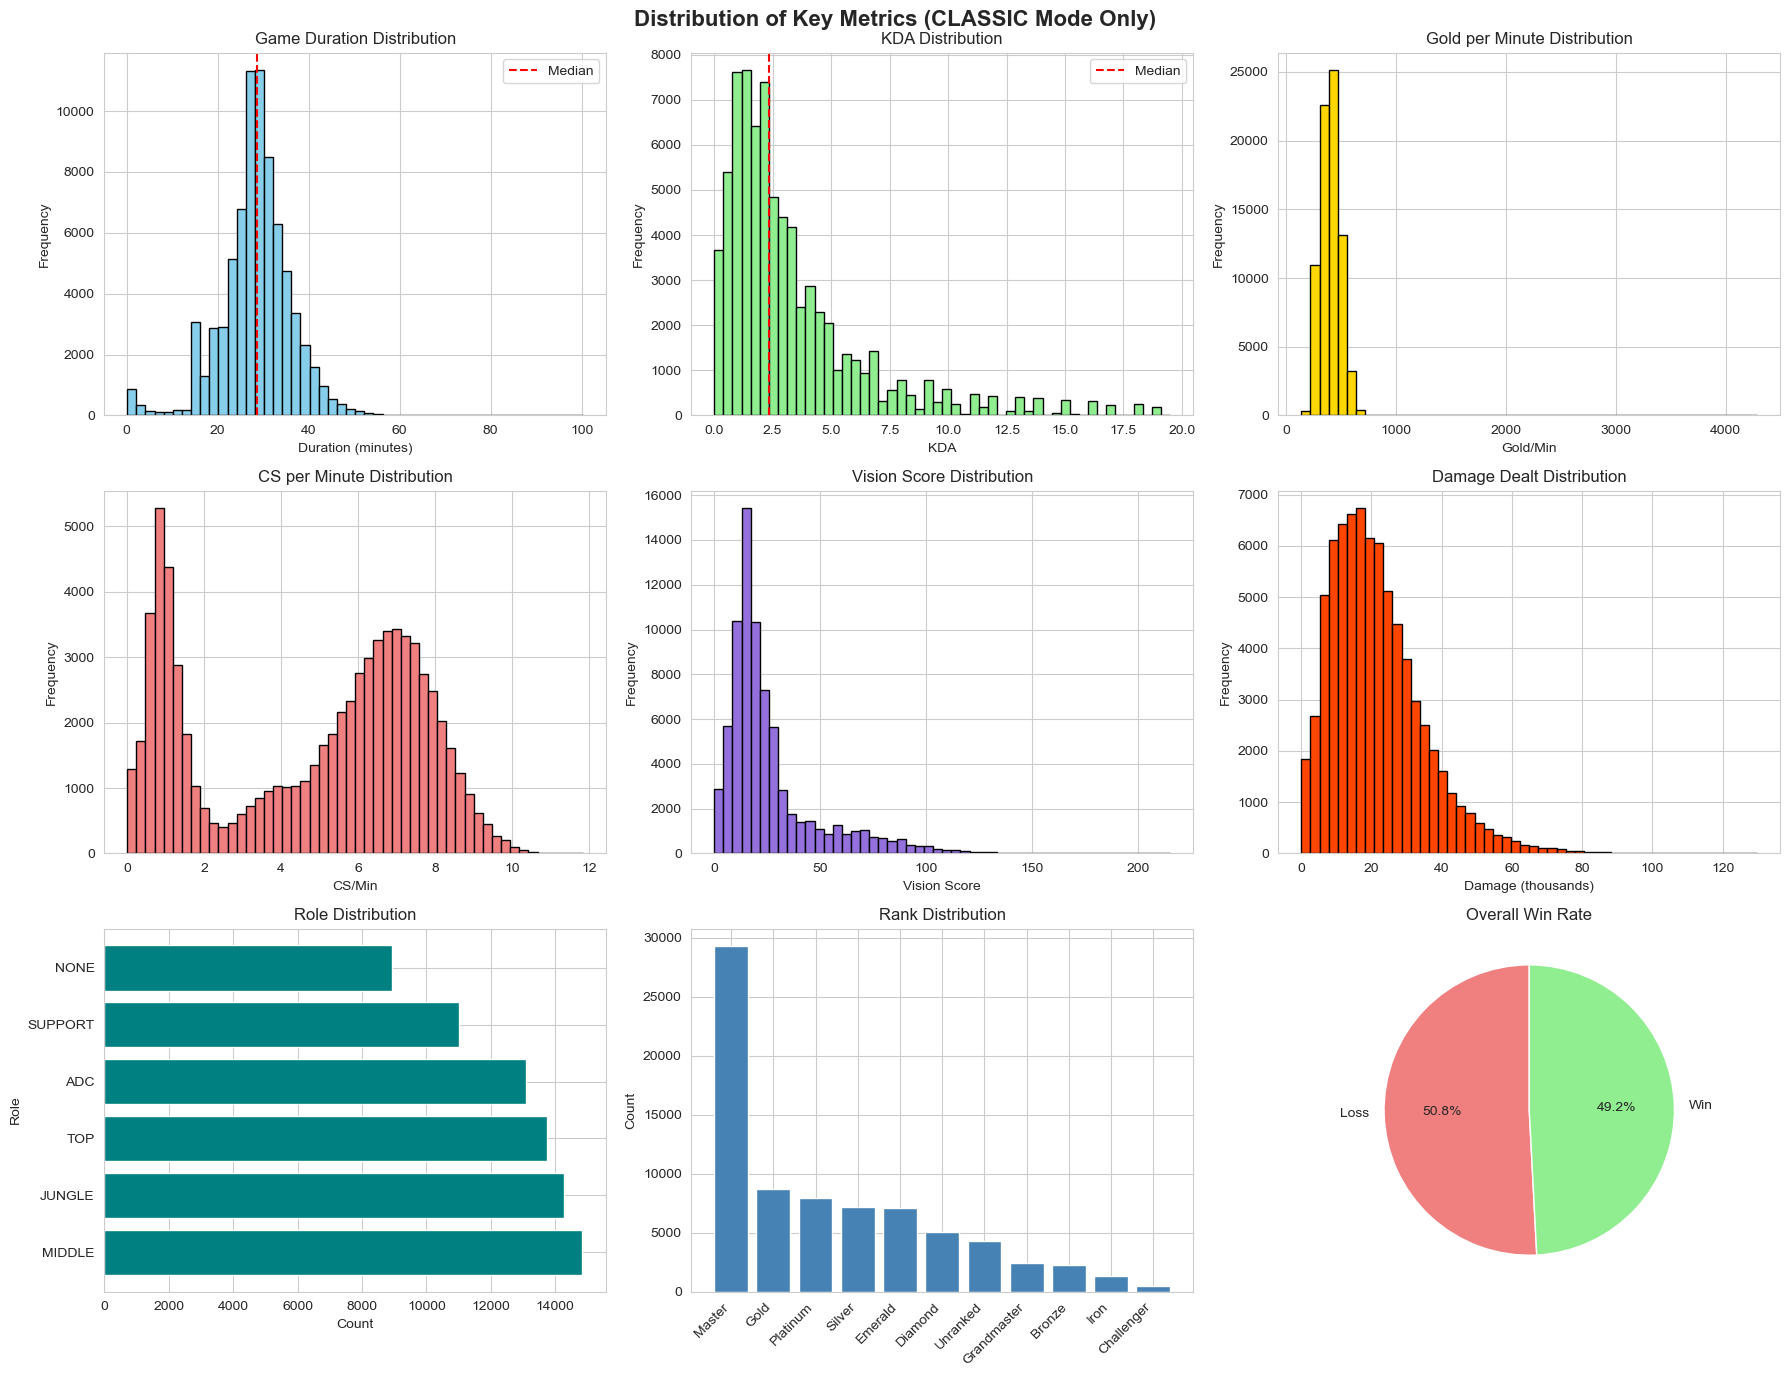

In [29]:
# Create a comprehensive distribution dashboard
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distribution of Key Metrics (CLASSIC Mode Only)', fontsize=16, fontweight='bold')

# 1. Game Duration
axes[0, 0].hist(match_stats_clean['GameDurationMin'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Game Duration Distribution')
axes[0, 0].set_xlabel('Duration (minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(match_stats_clean['GameDurationMin'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].legend()

# 2. KDA Distribution
kda_filtered = match_stats_clean[match_stats_clean['KDA'] < 20]
axes[0, 1].hist(kda_filtered['KDA'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('KDA Distribution')
axes[0, 1].set_xlabel('KDA')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(match_stats_clean['KDA'].median(), color='red', linestyle='--', label='Median')
axes[0, 1].legend()

# 3. Gold per Minute
axes[0, 2].hist(match_stats_clean['GoldPerMin'], bins=50, color='gold', edgecolor='black')
axes[0, 2].set_title('Gold per Minute Distribution')
axes[0, 2].set_xlabel('Gold/Min')
axes[0, 2].set_ylabel('Frequency')

# 4. CS per Minute
axes[1, 0].hist(match_stats_clean['CSPerMin'], bins=50, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('CS per Minute Distribution')
axes[1, 0].set_xlabel('CS/Min')
axes[1, 0].set_ylabel('Frequency')

# 5. Vision Score
axes[1, 1].hist(match_stats_clean['visionScore'], bins=50, color='mediumpurple', edgecolor='black')
axes[1, 1].set_title('Vision Score Distribution')
axes[1, 1].set_xlabel('Vision Score')
axes[1, 1].set_ylabel('Frequency')

# 6. Damage Dealt
axes[1, 2].hist(match_stats_clean['DmgDealt']/1000, bins=50, color='orangered', edgecolor='black')
axes[1, 2].set_title('Damage Dealt Distribution')
axes[1, 2].set_xlabel('Damage (thousands)')
axes[1, 2].set_ylabel('Frequency')

# 7. Role Distribution
role_counts = match_stats_clean['Role'].value_counts()
axes[2, 0].barh(role_counts.index, role_counts.values, color='teal')
axes[2, 0].set_title('Role Distribution')
axes[2, 0].set_xlabel('Count')
axes[2, 0].set_ylabel('Role')

# 8. Rank Distribution
rank_counts = match_stats_clean['RankName'].value_counts()
axes[2, 1].bar(range(len(rank_counts)), rank_counts.values, color='steelblue')
axes[2, 1].set_xticks(range(len(rank_counts)))
axes[2, 1].set_xticklabels(rank_counts.index, rotation=45, ha='right')
axes[2, 1].set_title('Rank Distribution')
axes[2, 1].set_ylabel('Count')

# 9. Win Rate
win_counts = match_stats_clean['Win'].value_counts()
colors_win = ['lightcoral', 'lightgreen']
axes[2, 2].pie(win_counts.values, labels=['Loss', 'Win'], autopct='%1.1f%%', 
               colors=colors_win, startangle=90)
axes[2, 2].set_title('Overall Win Rate')

plt.tight_layout()
plt.show()


### 5.2 Performance by Role


C:\Users\Kaw Bu\AppData\Local\Temp\ipykernel_12328\1289619615.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Kaw Bu\AppData\Local\Temp\ipykernel_12328\1289619615.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Kaw Bu\AppData\Local\Temp\ipykernel_12328\1289619615.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Kaw Bu\AppData\Local\Temp\ipykernel_12328\1289619615.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the

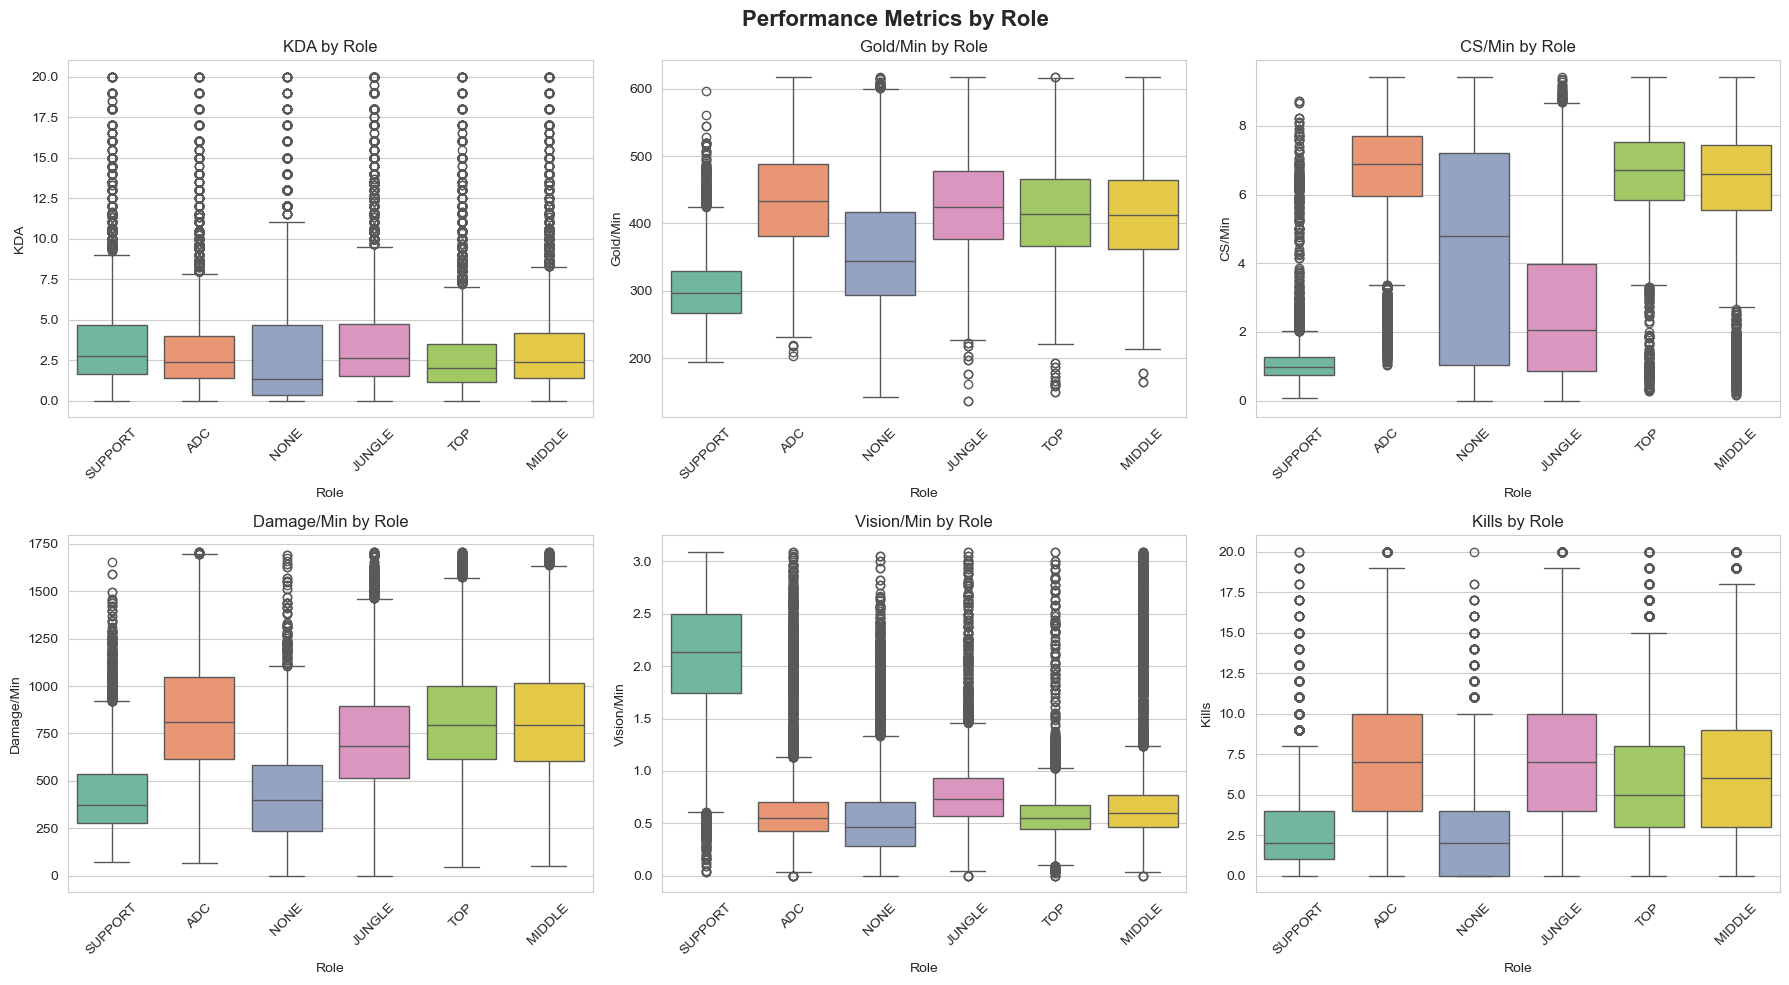


Average Performance by Role:


,KDA,GoldPerMin,CSPerMin,DmgPerMin,VisionPerMin,Win
Role,,,,,,
ADC,3.41,440.46,6.73,869.72,0.63,0.50
JUNGLE,4.19,430.97,2.62,730.14,0.78,0.50
MIDDLE,3.66,416.14,6.25,835.19,0.75,0.51
NONE,3.15,364.11,4.38,424.77,0.57,0.52
SUPPORT,4.24,302.10,1.15,434.05,2.15,0.52
TOP,3.00,420.35,6.65,832.23,0.58,0.51


In [30]:
# Box plots for key metrics by role
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Performance Metrics by Role', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('KDA', 'KDA'),
    ('GoldPerMin', 'Gold/Min'),
    ('CSPerMin', 'CS/Min'),
    ('DmgPerMin', 'Damage/Min'),
    ('VisionPerMin', 'Vision/Min'),
    ('kills', 'Kills')
]

for idx, (metric, label) in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    
    # Filter extreme outliers for better visualization
    data_filtered = match_stats_clean[match_stats_clean[metric] < match_stats_clean[metric].quantile(0.99)]
    
    sns.boxplot(data=data_filtered, x='Role', y=metric, ax=axes[row, col], palette='Set2')
    axes[row, col].set_title(f'{label} by Role')
    axes[row, col].set_xlabel('Role')
    axes[row, col].set_ylabel(label)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics by role
print("\nAverage Performance by Role:")
role_summary = match_stats_clean.groupby('Role').agg({
    'KDA': 'mean',
    'GoldPerMin': 'mean',
    'CSPerMin': 'mean',
    'DmgPerMin': 'mean',
    'VisionPerMin': 'mean',
    'Win': 'mean'
}).round(2)
display(role_summary)


### 5.3 Champion Analysis


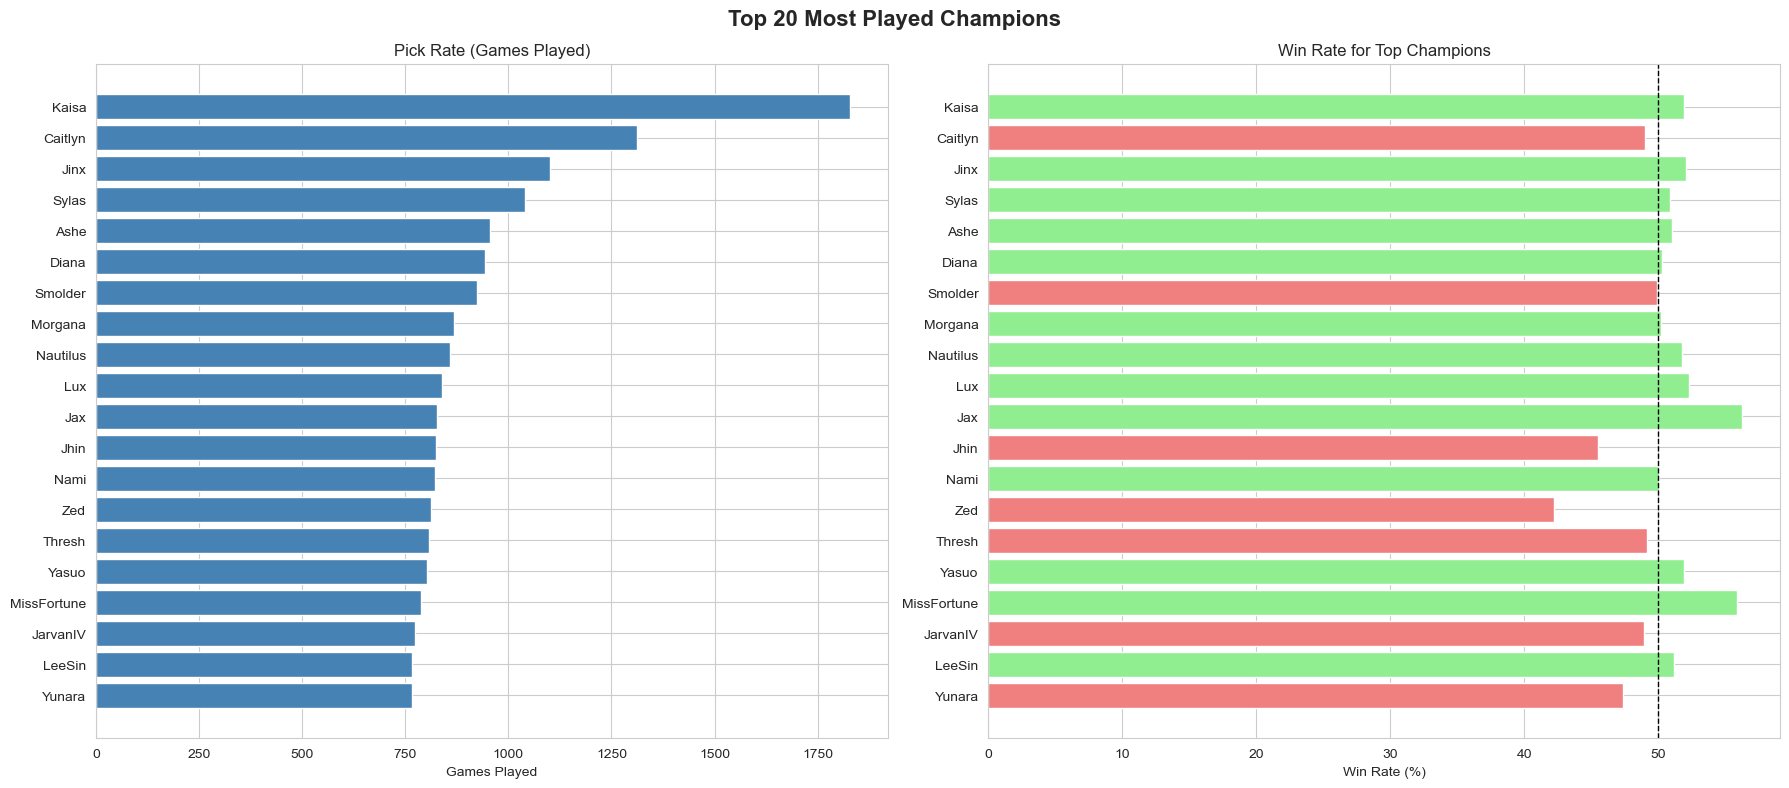


Top 20 Champions Summary:


,GamesPlayed,Win,KDA,GoldPerMin
ChampionName,,,,
Kaisa,1828,0.52,3.68,461.03
Caitlyn,1312,0.49,2.98,436.67
Jinx,1100,0.52,3.44,432.05
Sylas,1041,0.51,3.92,421.45
Ashe,955,0.51,3.31,407.11
Diana,944,0.50,3.49,441.41
Smolder,925,0.50,3.36,440.42
Morgana,869,0.50,4.26,353.61
Nautilus,859,0.52,3.51,294.75


In [31]:
# Champion statistics
champion_stats = match_stats_clean.groupby('ChampionName').agg({
    'MatchStatsId': 'count',
    'Win': 'mean',
    'KDA': 'mean',
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean',
    'GoldPerMin': 'mean',
    'DmgPerMin': 'mean'
}).rename(columns={'MatchStatsId': 'GamesPlayed'})

# Filter champions with at least 50 games for meaningful stats
champion_stats = champion_stats[champion_stats['GamesPlayed'] >= 50]
champion_stats = champion_stats.sort_values('GamesPlayed', ascending=False)

# Top 20 by pick rate
top_20_picks = champion_stats.head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Top 20 Most Played Champions', fontsize=16, fontweight='bold')

# Pick rate
axes[0].barh(range(len(top_20_picks)), top_20_picks['GamesPlayed'], color='steelblue')
axes[0].set_yticks(range(len(top_20_picks)))
axes[0].set_yticklabels(top_20_picks.index)
axes[0].set_xlabel('Games Played')
axes[0].set_title('Pick Rate (Games Played)')
axes[0].invert_yaxis()

# Win rate for top picks
colors = ['lightgreen' if wr > 0.5 else 'lightcoral' for wr in top_20_picks['Win']]
axes[1].barh(range(len(top_20_picks)), top_20_picks['Win'] * 100, color=colors)
axes[1].set_yticks(range(len(top_20_picks)))
axes[1].set_yticklabels(top_20_picks.index)
axes[1].set_xlabel('Win Rate (%)')
axes[1].set_title('Win Rate for Top Champions')
axes[1].axvline(50, color='black', linestyle='--', linewidth=1)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 20 Champions Summary:")
display(top_20_picks[['GamesPlayed', 'Win', 'KDA', 'GoldPerMin']].round(2))


### 5.4 Win Rate vs Pick Rate Interactive Scatter


In [32]:
# Interactive scatter plot with Plotly
fig = px.scatter(
    champion_stats.reset_index(),
    x='GamesPlayed',
    y='Win',
    hover_name='ChampionName',
    size='KDA',
    color='Win',
    color_continuous_scale='RdYlGn',
    labels={'GamesPlayed': 'Games Played (Pick Rate)', 
            'Win': 'Win Rate',
            'KDA': 'Avg KDA'},
    title='Champion Win Rate vs Pick Rate (Bubble Size = KDA)',
    height=600
)

fig.add_hline(y=0.5, line_dash="dash", line_color="gray", 
              annotation_text="50% Win Rate", annotation_position="right")

fig.update_layout(
    xaxis_title="Games Played",
    yaxis_title="Win Rate",
    yaxis_tickformat=".0%"
)

fig.show()

# Identify high win rate + high pick rate champions (meta champions)
meta_champs = champion_stats[(champion_stats['Win'] > 0.52) & (champion_stats['GamesPlayed'] > 200)].sort_values('Win', ascending=False)
print("\nMeta Champions (>52% WR, >200 games):")
display(meta_champs[['GamesPlayed', 'Win', 'KDA']].head(10).round(3))



Meta Champions (>52% WR, >200 games):


,GamesPlayed,Win,KDA
ChampionName,,,
Kled,238,0.613,3.316
Viktor,267,0.599,3.364
Poppy,379,0.599,4.008
Ivern,263,0.593,6.202
Seraphine,388,0.582,5.057
Fiddlesticks,201,0.582,3.887
Trundle,289,0.581,4.039
Corki,384,0.581,3.763
Tristana,673,0.579,3.389


### 5.5 Correlation Analysis


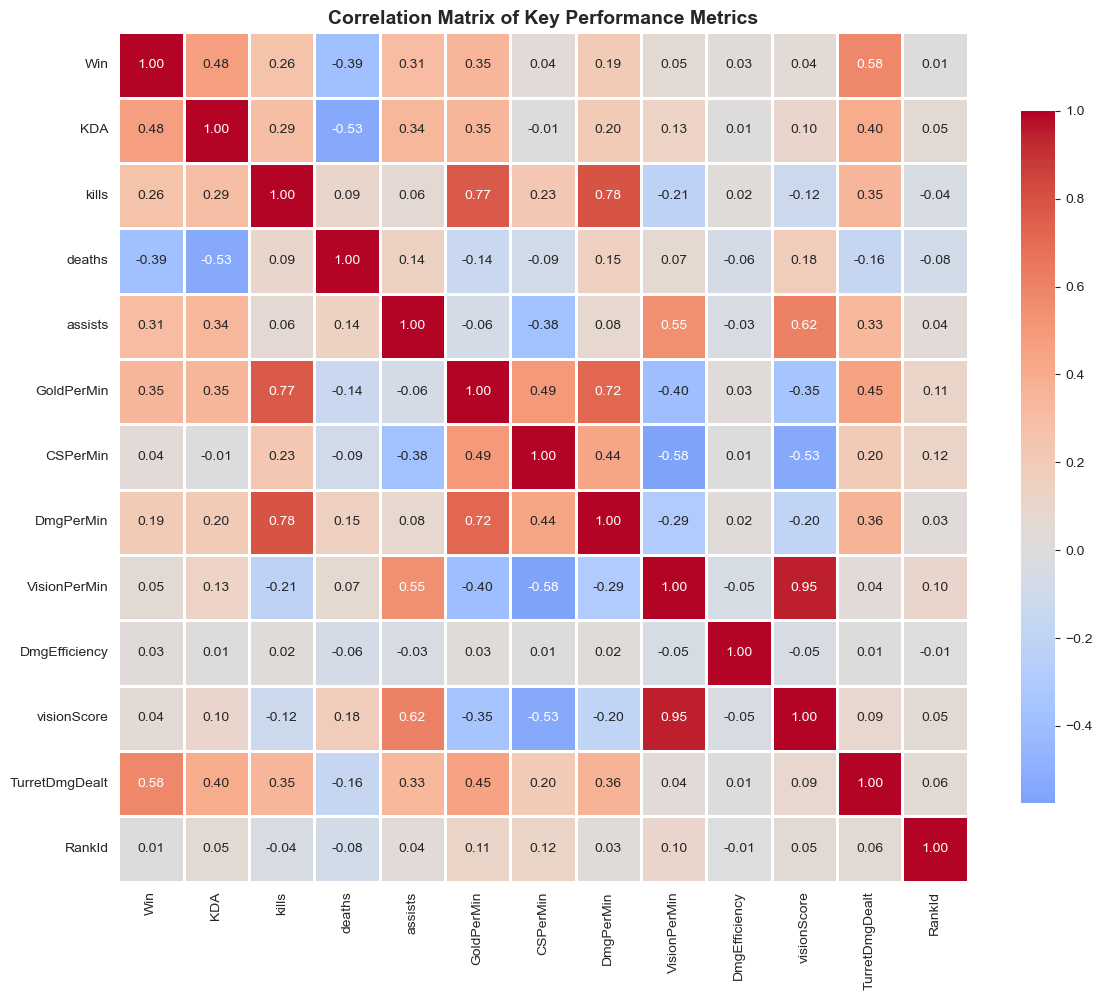


Strongest correlations with Win:
TurretDmgDealt    0.575970
KDA               0.476548
GoldPerMin        0.352800
assists           0.309549
kills             0.259309
DmgPerMin         0.194129
VisionPerMin      0.053277
visionScore       0.043961
CSPerMin          0.039884
DmgEfficiency     0.029091
Name: Win, dtype: float64


In [33]:
# Correlation matrix for key metrics

correlation_metrics = [
    'Win', 'KDA', 'kills', 'deaths', 'assists', 
    'GoldPerMin', 'CSPerMin', 'DmgPerMin', 'VisionPerMin',
    'DmgEfficiency', 'visionScore', 'TurretDmgDealt', 'RankId'
]

corr_matrix = match_stats_clean[correlation_metrics].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Key Performance Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print strongest correlations with Win
win_correlations = corr_matrix['Win'].sort_values(ascending=False)
print("\nStrongest correlations with Win:")
print(win_correlations[1:].head(10))


## 6. Export Clean Dataset


In [34]:
# Export cleaned dataset
output_file = 'data/league_match_stats_cleaned.csv'
match_stats_clean.to_csv(output_file, index=False)

print(f"Clean dataset exported to: {output_file}")
print(f"   Shape: {match_stats_clean.shape}")
print(f"   Rows: {len(match_stats_clean):,}")
print(f"   Columns: {len(match_stats_clean.columns)}")

# Also export champion summary
summary_output = 'data/league_champion_summary.csv'
champion_stats.to_csv(summary_output)
print(f"\nChampion summary exported to: {summary_output}")
print(f"   Champions analyzed: {len(champion_stats)}")


Clean dataset exported to: data/league_match_stats_cleaned.csv
   Shape: (75897, 56)
   Rows: 75,897
   Columns: 56

Champion summary exported to: data/league_champion_summary.csv
   Champions analyzed: 171


In [35]:
print("Summary of Changes")

print(f"\n Dataset Overview (after filtering to only classic mode):")
print(f"    Total matches: {matches_df['MatchId'].nunique():,}")
print(f"    Total player records: {len(match_stats_clean):,}")
print(f"    Unique summoners: {summoner_matches_df['SummonerFk'].nunique():,}")
print(f"    Unique champions: {match_stats_clean['ChampionFk'].nunique()}")
print(f"    Game mode: CLASSIC (Summoner's Rift) only")
print(f"    Patch range: {match_stats_clean['Patch'].min()} to {match_stats_clean['Patch'].max()}")

print(f"\n Data Cleaning Completed:")
print(f"    Filtering all other gamemodes")
print(f"    Distinguish ADC from Support")
print(f"    Cleaned {len(items_df)} item names (removed HTML tags)")
print(f"    Removed invalid champion records")
print(f"    Handled missing/infinite values")

print(f"\n Features Engineered:")
print(f"    KDA ratio")
print(f"    Per-minute metrics (Gold, CS, Damage, Vision)")
print(f"    Efficiency metrics (Damage per Gold, Damage Efficiency)")
print(f"    Game phase classification (Early/Mid/Late)")
print(f"    Item count")
print(f"    Objective participation")

print(f"\n Key Insights:")
print(f"    Overall win rate: {match_stats_clean['Win'].mean()*100:.1f}%")
print(f"    Average game duration: {match_stats_clean['GameDurationMin'].mean():.1f} minutes")
print(f"    Average KDA: {match_stats_clean['KDA'].mean():.2f}")
print(f"    Average CS/min: {match_stats_clean['CSPerMin'].mean():.2f}")
print(f"    Average vision score: {match_stats_clean['visionScore'].mean():.1f}")
print(f"    Most played champion: {champion_stats.index[0]} ({champion_stats.iloc[0]['GamesPlayed']:.0f} games)")


Summary of Changes

 Dataset Overview (after filtering to only classic mode):
    Total matches: 33,696
    Total player records: 75,897
    Unique summoners: 2,535
    Unique champions: 171
    Game mode: CLASSIC (Summoner's Rift) only
    Patch range: 13.22.541.9804 to 15.9.678.398

 Data Cleaning Completed:
    Filtering all other gamemodes
    Distinguish ADC from Support
    Cleaned 635 item names (removed HTML tags)
    Removed invalid champion records
    Handled missing/infinite values

 Features Engineered:
    KDA ratio
    Per-minute metrics (Gold, CS, Damage, Vision)
    Efficiency metrics (Damage per Gold, Damage Efficiency)
    Game phase classification (Early/Mid/Late)
    Item count
    Objective participation

 Key Insights:
    Overall win rate: 50.8%
    Average game duration: 28.4 minutes
    Average KDA: 3.62
    Average CS/min: 4.76
    Average vision score: 26.2
    Most played champion: Kaisa (1828 games)
